```{contents}
```


## Demonstration

### Import Dependencies


In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt




---

### Step 2 — Load and Preprocess the Dataset

We’ll use the **MNIST** dataset (28×28 grayscale digits).



In [9]:

# Load data
(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()

# Normalize pixel values (0–255 → 0–1)
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Reshape to fit CNN input (samples, height, width, channels)
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# One-hot encode labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)


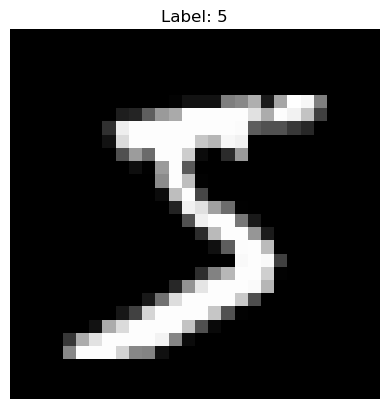

In [10]:
plt.imshow(X_train[0].reshape(28, 28), cmap='gray')
plt.title(f"Label: {y_train[0].argmax()}")
plt.axis('off')
plt.show()



---

### Define the CNN Model

This is a **feedforward CNN** for image classification.



In [11]:
def create_cnn_model(filters=32, kernel_size=3, dropout_rate=0.3, learning_rate=0.001):
    model = models.Sequential([
        layers.Conv2D(filters, (kernel_size, kernel_size), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(filters * 2, (kernel_size, kernel_size), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Flatten(),
        layers.Dropout(dropout_rate),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model




---

### Train the Base Model

Train with standard hyperparameters first.



In [12]:

model = create_cnn_model()
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=64,
    verbose=1
)


C:\Users\sangouda\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.8602 - loss: 0.4524 - val_accuracy: 0.9802 - val_loss: 0.0685
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.9780 - loss: 0.0696 - val_accuracy: 0.9871 - val_loss: 0.0464
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.9856 - loss: 0.0453 - val_accuracy: 0.9872 - val_loss: 0.0426
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.9882 - loss: 0.0362 - val_accuracy: 0.9894 - val_loss: 0.0359
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.9909 - loss: 0.0278 - val_accuracy: 0.9897 - val_loss: 0.0390
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.9922 - loss: 0.0252 - val_accuracy: 0.9890 - val_loss: 0.0375
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.9922 - loss: 0.0227 - val_accuracy: 0.9916 - val_loss: 0.0319
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.9941 - loss: 0.0181 - 



### Evaluate on Test Data


In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")




---

### Hyperparameter Tuning (Manual Search)

You can manually tune filters, dropout, and learning rate to improve results.



In [16]:
from sklearn.model_selection import ParameterGrid
import random

# Use a smaller subset for quick tuning
sample_idx = random.sample(range(len(X_train)), 10000)  # 10k samples instead of 60k
X_train_small = X_train[sample_idx]
y_train_small = y_train[sample_idx]

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)


# Define a smaller parameter grid
param_grid = {
    'filters': [32, 64],           # fewer values
    'kernel_size': [3],            # fixed kernel size
    'dropout_rate': [0.3],         # fixed dropout
    'learning_rate': [0.001, 0.0005]
}

best_acc = 0
best_params = {}

# Run fewer epochs and use validation split
for params in ParameterGrid(param_grid):
    print(f"Testing {params}")
    model = create_cnn_model(**params)
    
    model.fit(
        X_train_small, y_train_small,
        validation_split=0.1,
        epochs=3,                   # reduced from 5
        batch_size=128,             # larger batch size
        verbose=0,
        callbacks=[early_stop]
    )
    
    _, acc = model.evaluate(X_test[:2000], y_test[:2000], verbose=0)  # evaluate on subset
    print(f"Accuracy: {acc:.4f}")
    
    if acc > best_acc:
        best_acc = acc
        best_params = params

print("✅ Best Hyperparameters:", best_params)
print(f"✅ Best Accuracy: {best_acc:.4f}")


Testing {'dropout_rate': 0.3, 'filters': 32, 'kernel_size': 3, 'learning_rate': 0.001}


C:\Users\sangouda\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy: 0.9645
Testing {'dropout_rate': 0.3, 'filters': 32, 'kernel_size': 3, 'learning_rate': 0.0005}
Accuracy: 0.9510
Testing {'dropout_rate': 0.3, 'filters': 64, 'kernel_size': 3, 'learning_rate': 0.001}
Accuracy: 0.9655
Testing {'dropout_rate': 0.3, 'filters': 64, 'kernel_size': 3, 'learning_rate': 0.0005}
Accuracy: 0.9565
✅ Best Hyperparameters: {'dropout_rate': 0.3, 'filters': 64, 'kernel_size': 3, 'learning_rate': 0.001}
✅ Best Accuracy: 0.9655




---

### Training Visualization

Compare training and validation performance.



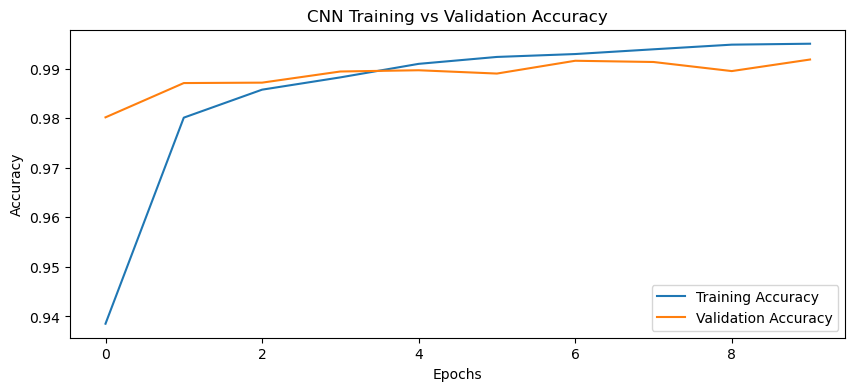

In [17]:
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('CNN Training vs Validation Accuracy')
plt.show()



### CNN Workflow Summary

| Step | Process                  | Purpose                            |
| ---- | ------------------------ | ---------------------------------- |
| 1    | Load and preprocess data | Normalize and reshape              |
| 2    | Build CNN                | Define conv, pooling, dense layers |
| 3    | Compile                  | Specify optimizer and loss         |
| 4    | Train                    | Fit model on data                  |
| 5    | Evaluate                 | Test accuracy                      |
| 6    | Tune                     | Optimize hyperparameters           |
| 7    | Visualize                | Track accuracy/loss trends         |

---



### Key CNN Components

| Layer            | Function                                         |
| ---------------- | ------------------------------------------------ |
| **Conv2D**       | Extracts spatial features (edges, textures)      |
| **MaxPooling2D** | Reduces spatial dimensions                       |
| **Dropout**      | Prevents overfitting by disabling random neurons |
| **Flatten**      | Converts 2D matrix → 1D vector                   |
| **Dense**        | Fully connected output layer                     |
| **Softmax**      | Converts logits into probability distribution    |

---

### Common CNN Hyperparameters to Tune

| Hyperparameter | Effect                    | Typical Range |
| -------------- | ------------------------- | ------------- |
| Filters        | Feature extraction depth  | 16–128        |
| Kernel Size    | Receptive field           | 3×3 or 5×5    |
| Dropout Rate   | Regularization            | 0.2–0.5       |
| Learning Rate  | Weight update step size   | 1e-4 to 1e-2  |
| Batch Size     | Samples per gradient step | 32–128        |
| Epochs         | Number of training passes | 10–50         |

---

### Insights

* **Dropout** combats overfitting by regularizing dense layers.
* **Adam optimizer** provides adaptive learning rate.
* **Batch normalization** (optional) can stabilize training.
* **Early stopping** halts when validation loss stops improving.

---

**Final Takeaway**

> CNNs learn **spatial hierarchies of features** using convolution + pooling layers.
> Training involves minimizing **cross-entropy loss**, and **hyperparameter tuning** refines model depth, learning rate, and regularization strength for best generalization.

